In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os
import glob

In [2]:
def mean_shift_opt2(data, radius):
    labels = np.full(len(data), fill_value=-1, dtype=int)
    
    ### BEGIN SOLUTION
    peaks = np.empty(data.shape)
    n_peaks = 0
    
    for idx, query in enumerate(data):
        # Skip point if it already has a valid label assigned (speed-up 1&2에 해당하는 것들은 해당 작업을 수행하지 않는다.)
        if labels[idx] != -1:
            continue
            
        peak, is_near_search_path = find_peak_opt(data, query, radius)
        label = None
        
        # Compare found peak to existing peaks
        if n_peaks > 0:
            dist = np.linalg.norm(peaks[:n_peaks] - peak, axis=1)
            label_of_nearest_peak = np.argmin(dist)
            
            # If the nearest existing peak is near enough, take its label
            if dist[label_of_nearest_peak] <= radius / 2:
                label = label_of_nearest_peak
        
        # No existing peak was near enough, create new one
        if label is None:
            label = n_peaks
            peaks[label] = peak
            n_peaks += 1
            
            # SPEEDUP 1: give same label to points near the peak
            dist = np.linalg.norm(data - peak, axis=1)
            labels[dist <= radius] = label
            
        # SPEEDUP 2: give same label to points that were near the search path
        labels[is_near_search_path] = label
    
    peaks = peaks[:n_peaks]
    ### END SOLUTION
    
    return peaks, labels

In [3]:
def mean_shift_segment(im, radius):
    data = im.reshape(-1, 3).astype(float)
    peaks, labels = mean_shift_opt2(data, radius)  # mean_shift(data, radius)
    print(peaks, labels,labels.max())
    segmented_im = peaks[labels].reshape(im.shape).astype(np.uint8)
    return data, peaks, labels, segmented_im

In [4]:
def find_peak_opt(data, query, radius, c=3):
    is_near_search_path = np.zeros(len(data), dtype=bool)
    
    ### BEGIN SOLUTION
    shift = np.inf
    while shift > 0.1:
        dist = np.linalg.norm(data - query, axis=1)
        query_old = query
        query = np.mean(data[dist <= radius], axis=0)
        shift = np.linalg.norm(query - query_old)
        # SPEEDUP 2:
        is_near_search_path[dist <= radius/c] = True
   
    return query, is_near_search_path

In [5]:
def make_label_colormap():
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, 20)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return matplotlib.colors.ListedColormap(colors)

In [6]:
def plot_3d_clusters(ax, data, labels, peaks, 
                     peak_colors=None, colors=None, axis_names='xyz'):
    """Plots a set of point clusters in 3D, each with different color."""

    def luv2rgb(color):
        expanded = color[np.newaxis, np.newaxis]
        rgb = cv2.cvtColor(expanded.astype(np.uint8), cv2.COLOR_BGR2HSV)
        return rgb[0,0]/255
      
    if peak_colors is None:
        peak_colors = peaks
    
    for label in range(len(peaks)):
        if colors=='rgb':
            cluster_color = color = peak_colors[label]/255
        elif colors=='luv':
            cluster_color = luv2rgb(peak_colors[label])
        elif colors==''
        else:
            cluster_color=None

        cluster = data[labels==label]
        ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2],
                   alpha=0.15, color=cluster_color)
        ax.scatter(peaks[label, 0], peaks[label, 1], peaks[label, 2], 
                   color='black', marker='x', s=150, linewidth=3)

In [7]:
x_files =  glob.glob('..\\set_images\\*.png')
x_file = x_files[6]

In [8]:
label_cmap = make_label_colormap()

im = cv2.imread(x_file)
im = cv2.medianBlur(im,3)
im = cv2.resize(im,(128,128))
# im = imageio.imread(x_file)
start_time = time.time()
data, peaks, labels, segmented_im = mean_shift_segment(im, radius=40) # 여기서 radius를 바꾸면 얼마나 sensitive하게 cluster의 종류가 생기는지 체크 가능.
duration= time.time()-start_time
# print(f'Took {duration:.2f} s')

[[108.72490086  96.9298685  103.07973283]
 [ 50.75384417  49.8349916   61.69233751]
 [ 65.26315789 171.15789474 130.24561404]] [0 0 0 ... 0 0 0] 2


<IPython.core.display.Javascript object>


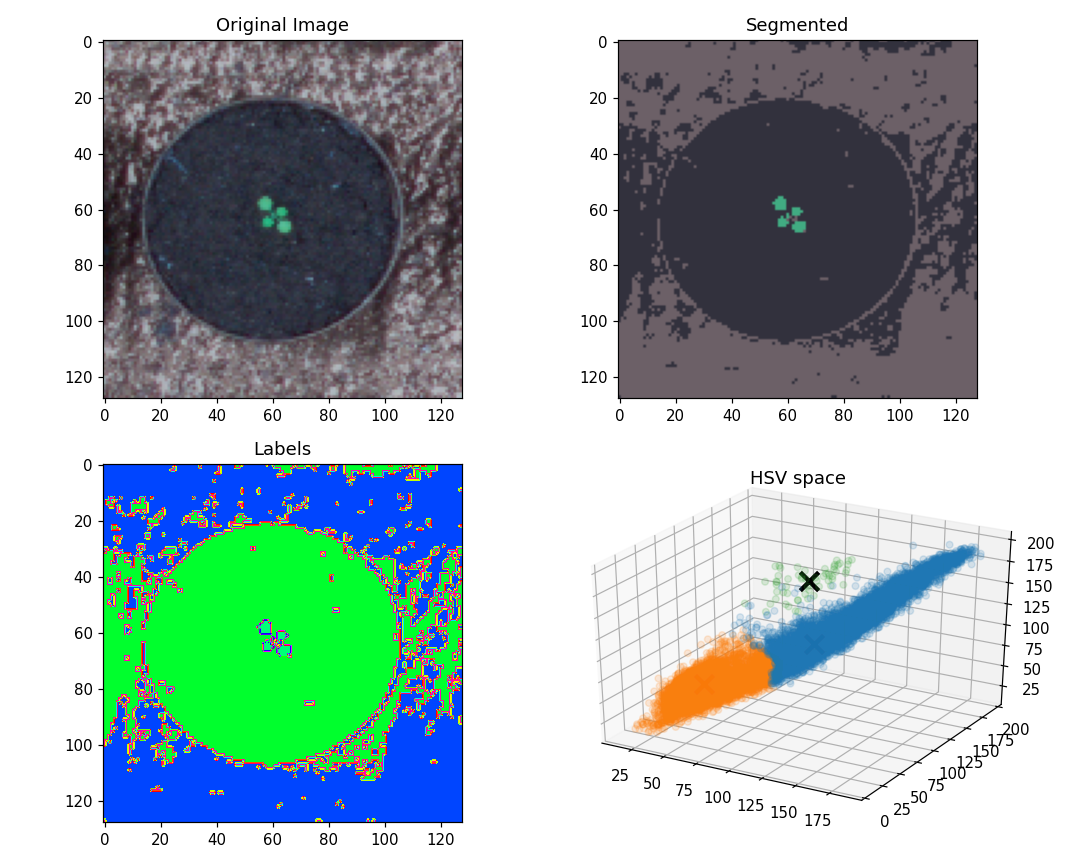

In [9]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Original Image')
ax.imshow(im)

ax = fig.add_subplot(2, 2, 2)
ax.set_title('Segmented')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 2, 3)
ax.set_title('Labels')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title(f'HSV space')
plot_3d_clusters(ax, data, labels, peaks, colors='hsv', axis_names='HSV')
fig.tight_layout()